### Notes about the project
At the beginning of the project we did some EDA on the data available. We agreed that the Data was sparse and required extensive cleaning and filling in the gaps, which took most of the time working on the project.

Here is an abbreviated noteboo showing some parts of the EDA. Unfortunately the data itself is not available but you can get an idea of the process from the steps below.

First I visuzlied the key findings about the dataset (what's available, what's missing etc.), then after I talked to the team I did some graphs on the items that they were most interested about and suggested a few ways of how we could get additional data and compensate for missing data.

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [287]:
#NOTE That the data isn't available as it is propriatary for the startup I worked with
#loading data
df = pd.read_csv("./XXX DATA.csv")

In [288]:
df.shape

(15512, 25)

### Description of the data

Data was merged from several tables on co_id field and very sparse. Different sets available for different observations. For example certain features were only available for less than 5% of the dataset. While other features were available for virtually all observations. 

In [289]:
#check how many missing values in each column in the df, put in df_view so it's easier to see
#can't do df.decribe bc it only works on integers and floats and most of these are strings

df_view = pd.DataFrame(columns=['columns'])
df_view['columns'] = df.columns
df_view['missing_records'] = [df[i].isnull().sum() for i in df.columns]
df_view['all_records'] = [len(df[i]) for i in df.columns]
df_view['%missing_records'] = df_view["missing_records"] / df_view['all_records']
df_view['number_unique_records'] = [df[i].nunique() for i in df.columns]

df_view.sort_values('missing_records', ascending = False)

,columns,missing_records,all_records,%missing_records,number_unique_records
12,stage,14831,15512,0.956099,5
16,average_rating,13773,15512,0.887893,76
20,concept_pitch,12132,15512,0.782104,3323
19,short_description,10871,15512,0.700812,4513
10,product_type,10554,15512,0.680376,208
11,sales_model,10409,15512,0.671029,1048
9,customer_type,10406,15512,0.670835,1923
22,app_submit_date,10319,15512,0.665227,4967
21,custom_attributes,10319,15512,0.665227,1515
15,total_raised,9416,15512,0.607014,618


### Checking how long the clients have been using the platform
First calculating the length from signing up until the current date (validated with the startup that that's the approach they would like to use here). Then plotting it for vizualization.

In [314]:
from datetime import date
df['created'] = pd.to_datetime(df['created'])
df['updated'] = pd.to_datetime(df['updated'])
df['time_using_platform'] = date.today() - df['updated']
df['updated'] = pd.to_datetime(df['time_using_platform'])

In [315]:
df.time_using_platform.value_counts()[:5]
#what happened 253 (Oct 31, 2017) and 803 (Apr 29, 2016) days ago? Spikes in account creation.

253 days    1443
803 days    1025
637 days     373
337 days     246
294 days     206
Name: time_using_platform, dtype: int64

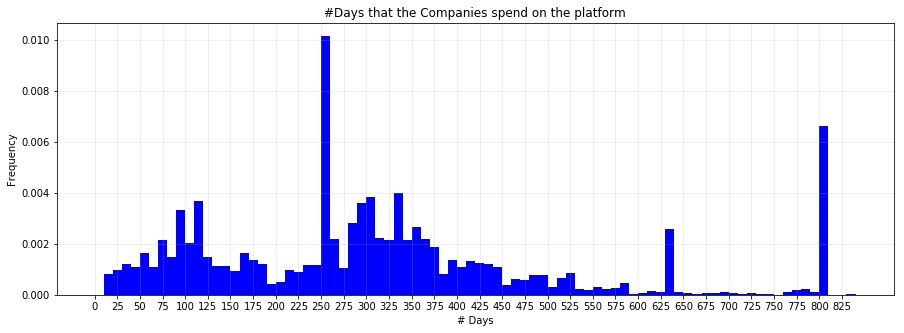

In [365]:
plt.figure(figsize=(15,5))

bins = np.arange(0,850,10)
plt.hist([np.clip(df.time_using_platform.astype('timedelta64[D]'), bins[0], bins[-1])],
                                density=True,
                                bins=bins, facecolor='b');

plt.title('#Days that the Companies spend on the platform')
plt.xlabel('# Days')
plt.ylabel('Frequency')

plt.xticks (np.arange(0, 850, step=25))
#plt.yticks (np.arange(0, 2200, step=100))
#plt.axis([0, 900, 0, 0.05])
plt.grid(True, alpha = 0.25 )

plt.show()

### Plotting for the NLP features
Since I will be using text for my recommender engine later, I am not looking at the available text fields to then decide witht the client how much text do we need at a minimum for them to make a decision.

In [297]:
# descriptions - since there are thee columns with descriptions, I am combining it into one, 
# so I can decide whether a company provided a description at all
df['text_description'] = df["description"].astype(str) + "" + df['short_description'].astype(str) + "" + df['concept_pitch'].astype(str)


# adding length of description column for easier plottings
length = []
for i in df.index:
    length.append(len(df.text_description[i].split()) - 1) #-1 to get rid of NaNs
    
df['text_length'] = length

In [298]:
df['text_length'].describe()

count    15512.000000
mean        27.164260
std         41.036809
min          0.000000
25%          0.000000
50%         14.000000
75%         38.000000
max       1381.000000
Name: text_length, dtype: float64

In [299]:
#looking at companies that did not provide any description
print("{} % of companies did not provide company description.".format(sum(df.text_length == 0)/ len(df.text_length))) 

0.37216348633316143 % of companies did not provide company description.


In [300]:
# here are the top ten description lengths
df.text_length.value_counts()[:5]

0     5773
36     216
38     208
37     208
35     201
Name: text_length, dtype: int64

Turns out someone submitted a copy of their homepage html instead of description, but other than that all entries were less than 216 words long.

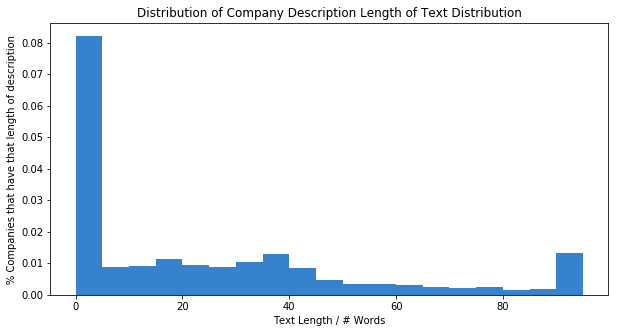

In [353]:
plt.figure(figsize=(10,5))
bins = np.arange(0,100,5)
plt.hist([np.clip(df.text_length, bins[0], bins[-1])],
                                density=True,
                                bins=bins, color=['#3782CC'])
plt.title('Distribution of Company Description Length of Text Distribution')
plt.xlabel('Text Length / # Words')
plt.ylabel('% Companies that have that length of description')

plt.show()

### Looking at correlations between some features
Cehcking whether the length of company description correlates with the length of the use of the platform. More interesting correlations were found with other features but not including here for proprietary info reasons.

In [198]:
df_tu = df[['time_using_platform', 'text_length']]
df_tu['time_using_platform'] = df_tu['time_using_platform'].astype('timedelta64[D]')

/Users/veraburfield/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


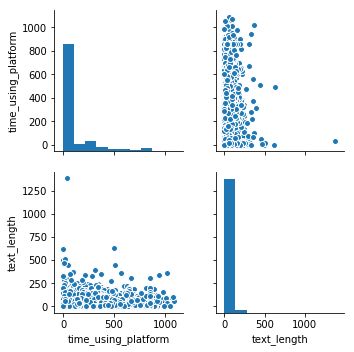

In [204]:
import seaborn as sns
sns.pairplot(df_tu)

In [220]:
df_tu.length_using_platform = round(df_round.length_using_platform)
pd.crosstab(df_tu.text_length, df_round.length_using_platform)

/Users/veraburfield/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


average_rating,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
stage,,,,,,,,,,
discovery,1,0,0,1,2,6,10,14,2,1
exploration-ideation,0,1,1,0,2,3,4,2,0,0
scale,0,0,0,0,4,2,3,10,1,3
validate-problem-solution,0,0,0,0,4,12,15,10,8,3


In [ ]:
#so this could be cool to know. right now most "XXX" info is missing and only a few hundred crosstab hits